In [2]:
import sys; sys.path.append('..'); from wwa import *

Xn, Xx, Yn, Yx = [-67,-47,-27,-7]
xn, xx, yn, yx = [-60,-54,-23,-15]
mapproj = cartopy.crs.PlateCarree()

In [2]:
sf = gpd.read_file("sf/pantanal")

In [3]:
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

# Physical geography

In [107]:
elev = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data).sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx))
kg = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc")).kg_cat.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx))

In [108]:
sf_hybas = gpd.read_file("sf/hybas_br-bo")
sf_biomas = gpd.read_file("sf/pantanal")

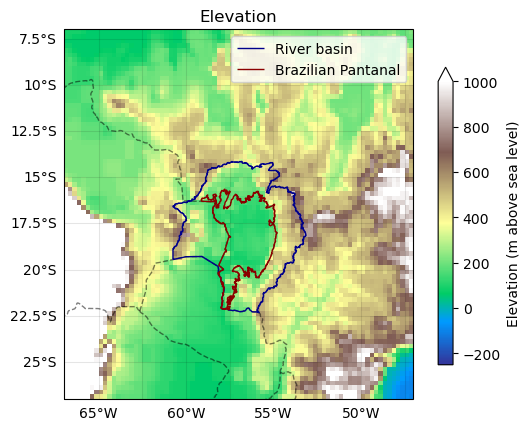

In [109]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, sharex = True, sharey = True)

elev.plot(ax = ax, cmap = "terrain", vmin = -500, vmax = 2000, 
          cbar_kwargs = {"location" : "right", "label" : "Elevation (m above sea level)", "fraction" : 0.03})
ax.set_title("Elevation")

sf_hybas.boundary.plot(ax = ax, lw = 1, color = "darkblue", label = "River basin")
sf_biomas.boundary.plot(ax = ax, color = "darkred", lw = 1, label = "Brazilian Pantanal")
ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
ax.gridlines(draw_labels = ["bottom", "left"], color = "k", alpha = 0.1)

ax.legend()

plt.savefig("fig/geog_elevation.png")

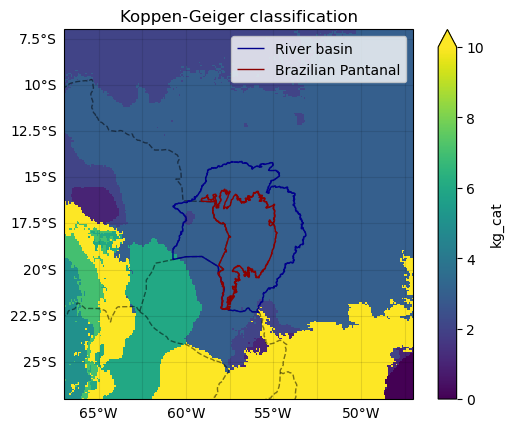

In [50]:
fig, ax = plt.subplots(subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)}, sharex = True, sharey = True)

kg.plot(ax = ax, vmin = 0, vmax = 10)
ax.set_title("Koppen-Geiger classification")

sf_hybas.boundary.plot(ax = ax, lw = 1, color = "darkblue", label = "River basin")
sf_biomas.boundary.plot(ax = ax, color = "darkred", lw = 1, label = "Brazilian Pantanal")
ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
ax.gridlines(draw_labels = ["bottom", "left"], color = "k", alpha = 0.1)
ax.legend()

plt.savefig("fig/geog_koppen-geiger.png")

# Fire indices & active fires

## Maps of DSR & active fires

In [12]:
# load active fire pixels, convert to geodataframe (standard lat-lon coords) & reproject geometry
df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326")

In [13]:
dsr = xr.open_dataset("data/era5_dsr.nc").dsr
dsr_m = dsr.resample(time = "MS").mean()

In [14]:
fwi = xr.open_dataset("data/era5_fwi_-67_-47_-27_-7.nc").fwinx
fwi_m = fwi.resample(time = "MS").mean()

In [15]:
sites = ["San Jose de Chiquitos, BO", "Corumba, BR", "Porto Esperanca, BR"]
px = {s : get_latlon(s) for s in sites}

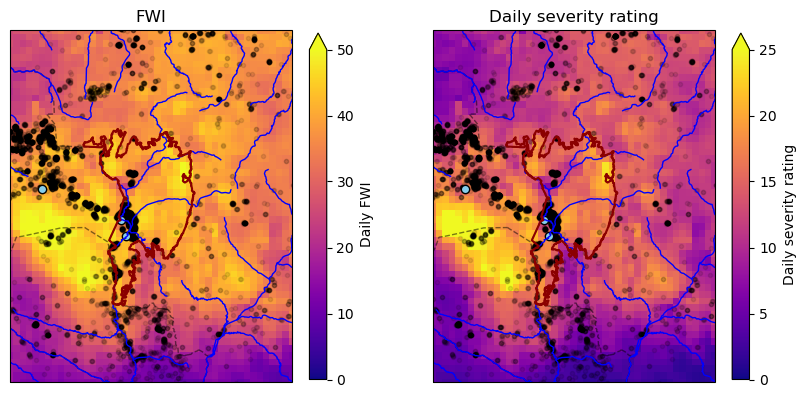

In [18]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,6), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plot_kwargs = {"vmin" : 0, "cmap" : "plasma", "add_colorbar" : True}
cbar_kwargs = {"shrink" : 0.75}

ax = axs[1]
dsr_m.sel(time = "2024-06").plot(ax = ax, **plot_kwargs, vmax = 25, cbar_kwargs = cbar_kwargs | {"label": "Daily severity rating"})
ax.set_title("Daily severity rating")

ax = axs[0]
fwi_m.sel(time = "2024-06").plot(ax = ax, **plot_kwargs, vmax = 50, cbar_kwargs = cbar_kwargs | {"label": "Daily FWI"})
ax.set_title("FWI")

for ax in axs:
    df.loc["2024-06"].plot(ax = ax, marker = ".", color = "k", alpha = 0.1)

    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue")

    sf.boundary.plot(ax = ax, color = "darkred")
    ax.scatter([v["lon"] for k,v in px.items()], [v["lat"] for k,v in px.items()], color = "skyblue", marker = "o", edgecolor = "k")

plt.savefig("fig/dsr-2406.png")

## Monthly DSR

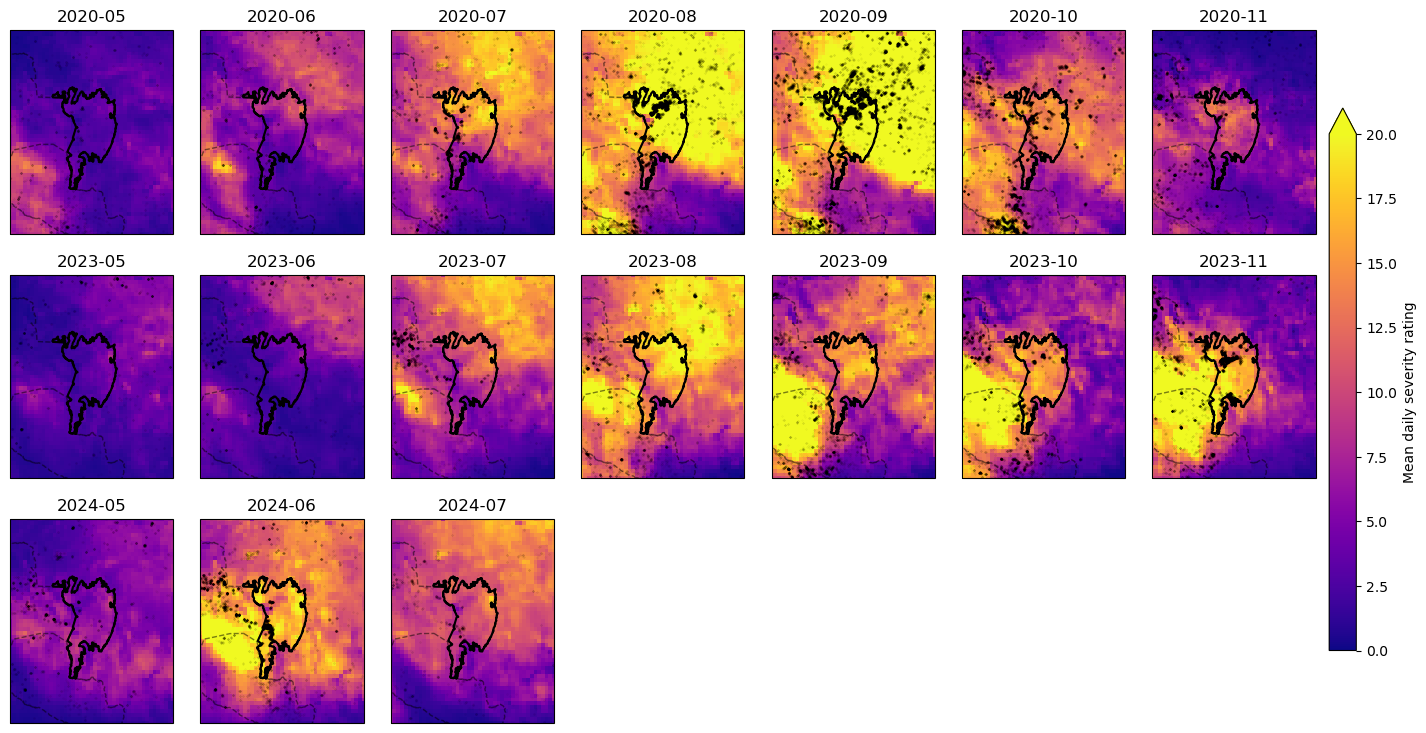

In [99]:
nc = 7; nr = 3
fig, axs = plt.subplots(nr, nc, figsize = (nc * 2.5, nr*3), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(wspace = 0.1)

plot_kwargs = {"vmin" : 0, "vmax" : 20, "cmap" : "plasma"}

for j in range(nr):
    y = [2020,2023,2024][j]
    
    for i in range(nc):
        
        m = str(y)+"-"+str(range(5,12)[i]).rjust(2,"0")
        ax = axs[j,i]
        
        if m > "2024-07":
            ax.set_axis_off()
            continue
        
        cbar = dsr_m.sel(time = m).plot(ax = ax, **plot_kwargs, add_colorbar = False)
        df.loc[m].plot(ax = ax, marker = ".", color = "k", alpha = 0.1, markersize = 0.25)

        ax.set_title(m)
        ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
        sf.boundary.plot(ax = ax, color = "k")
        
plt.colorbar(cbar, ax = axs, label = "Mean daily severity rating", extend = "max", shrink = 0.95, pad = 0.01, fraction = 0.02)

plt.savefig("fig/dsr-monthly.png")

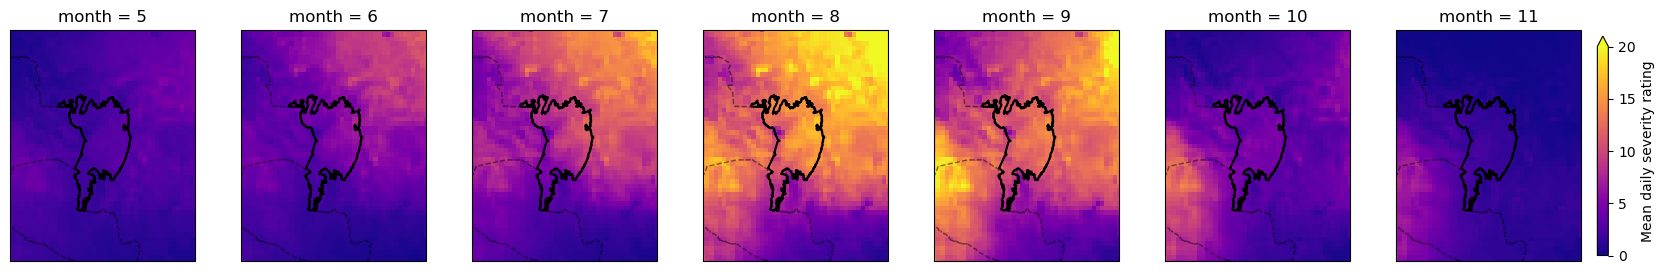

In [101]:
dsr_clim = dsr.sel(time = slice("2000","2020")).groupby("time.month").mean()

nc = 7; nr = 1
fig, axs = plt.subplots(nr, nc, figsize = (nc * 3, nr*3), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})

plot_kwargs = {"vmin" : 0, "vmax" : 20, "cmap" : "plasma"}
    
for i in range(nc):

    m = str(y)+"-"+str(range(5,12)[i]).rjust(2,"0")
    ax = axs[i]

    cbar = dsr_clim.sel(month = i+5).plot(ax = ax, **plot_kwargs, add_colorbar = False)

    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    sf.boundary.plot(ax = ax, color = "k")
    
plt.colorbar(cbar, ax = axs, label = "Mean daily severity rating", extend = "max", shrink = 0.95, pad = 0.01, fraction = 0.02)

plt.savefig("fig/dsr-clim.png")

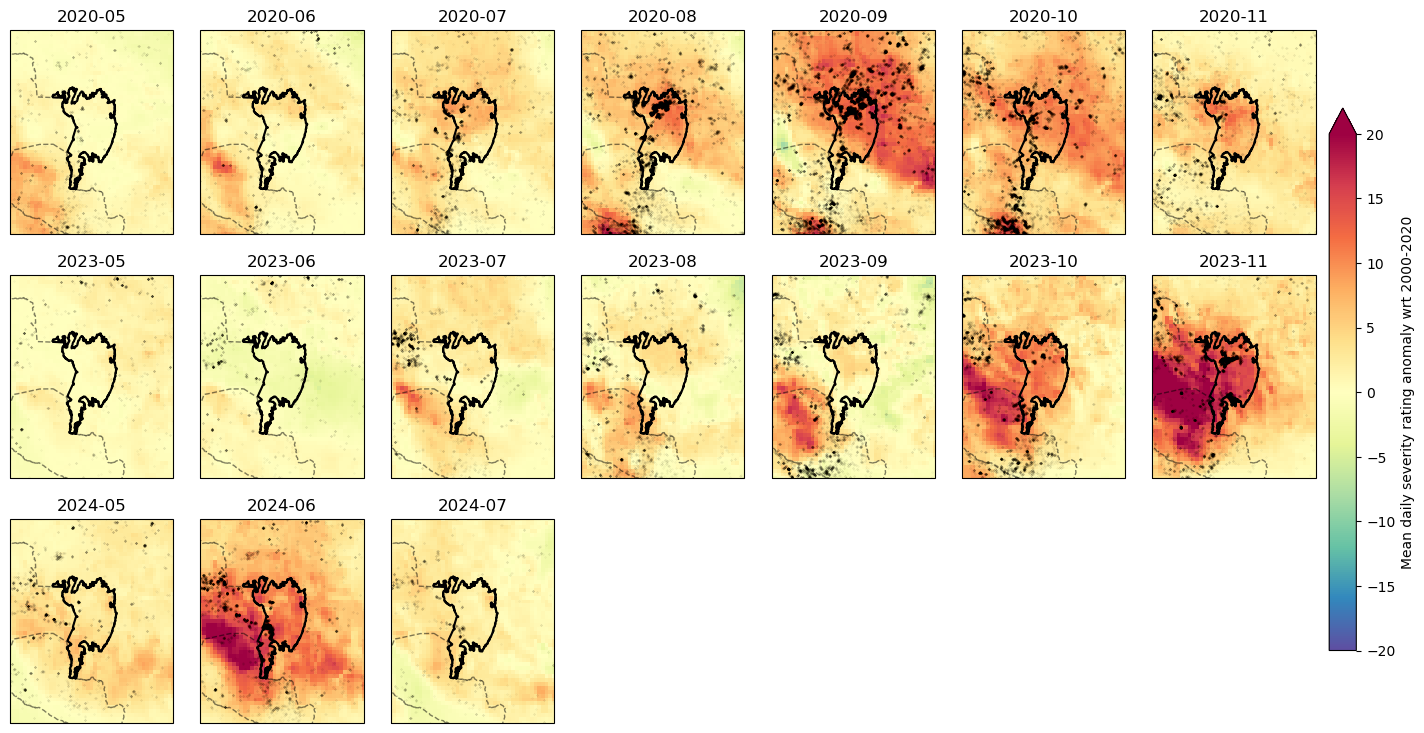

In [102]:
dsr_anom = dsr_m.groupby("time.month") - dsr_clim

nc = 7; nr = 3
fig, axs = plt.subplots(nr, nc, figsize = (nc * 2.5, nr*3), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(wspace = 0.1)

v = 20
plot_kwargs = {"vmin" : -v, "vmax" : v, "cmap" : "Spectral_r"}

for j in range(nr):
    y = [2020,2023,2024][j]
    
    for i in range(nc):
        
        m = str(y)+"-"+str(range(5,12)[i]).rjust(2,"0")
        ax = axs[j,i]
        
        if m > "2024-07":
            ax.set_axis_off()
            continue
        
        cbar = dsr_anom.sel(time = m).plot(ax = ax, **plot_kwargs, add_colorbar = False)
        df.loc[m].plot(ax = ax, marker = ".", color = "k", alpha = 0.1, markersize = 0.25)

        ax.set_title(m)
        ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
        sf.boundary.plot(ax = ax, color = "k")
        
plt.colorbar(cbar, ax = axs, label = "Mean daily severity rating anomaly wrt 2000-2020", extend = "max", shrink = 0.95, pad = 0.01, fraction = 0.02)

plt.savefig("fig/dsr-anom.png")

## Monthly FWI

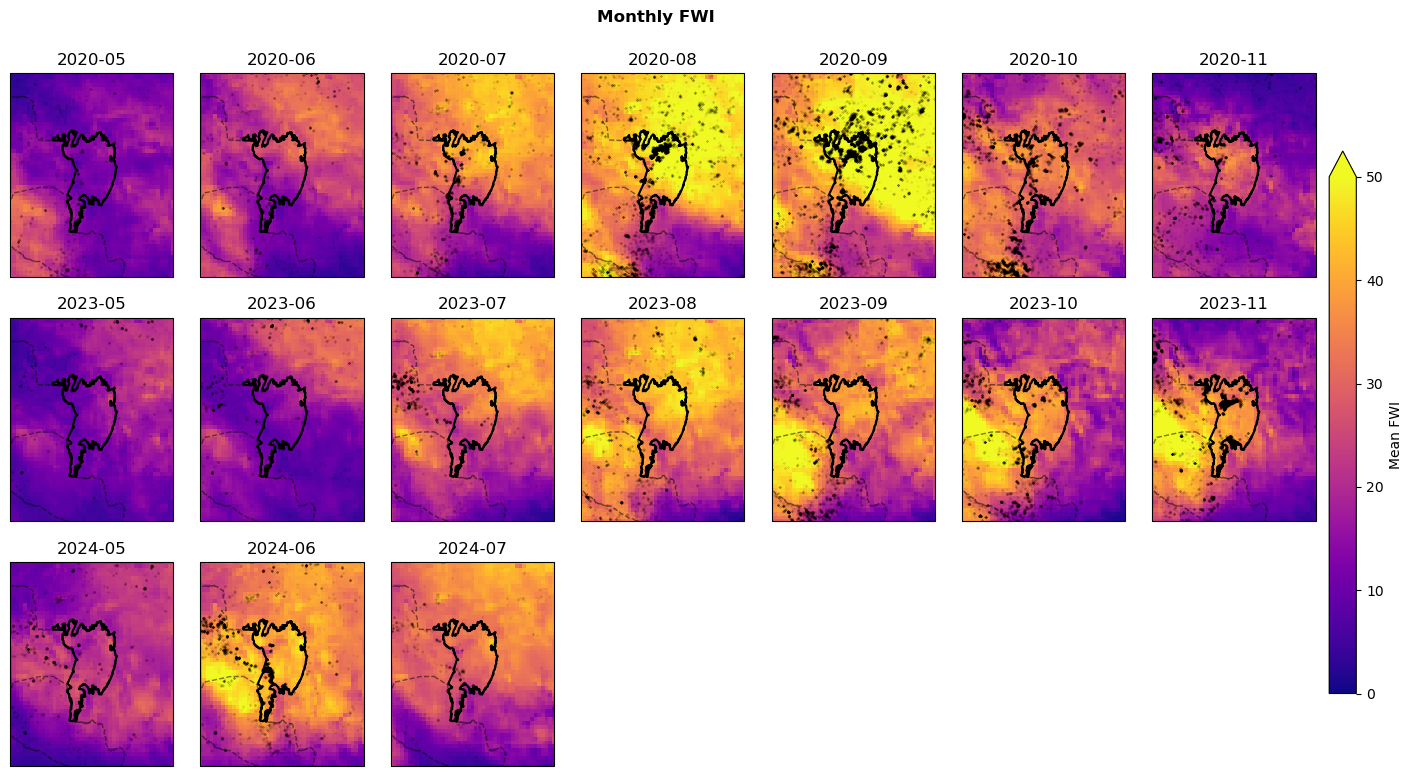

In [26]:
nc = 7; nr = 3
fig, axs = plt.subplots(nr, nc, figsize = (nc * 2.5, nr*3), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(wspace = 0.1)

plot_kwargs = {"vmin" : 0, "vmax" : 50, "cmap" : "plasma"}

for j in range(nr):
    y = [2020,2023,2024][j]
    
    for i in range(nc):
        
        m = str(y)+"-"+str(range(5,12)[i]).rjust(2,"0")
        ax = axs[j,i]
        
        if m > "2024-07":
            ax.set_axis_off()
            continue
        
        cbar = fwi_m.sel(time = m).plot(ax = ax, **plot_kwargs, add_colorbar = False)
        df.loc[m].plot(ax = ax, marker = ".", color = "k", alpha = 0.1, markersize = 0.25)

        ax.set_title(m)
        ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
        sf.boundary.plot(ax = ax, color = "k")
        
plt.colorbar(cbar, ax = axs, label = "Mean FWI", extend = "max", shrink = 0.95, pad = 0.01, fraction = 0.02)

plt.suptitle("Monthly FWI", fontweight = "bold", y = 0.95)


plt.savefig("fig/fwi-monthly.png")

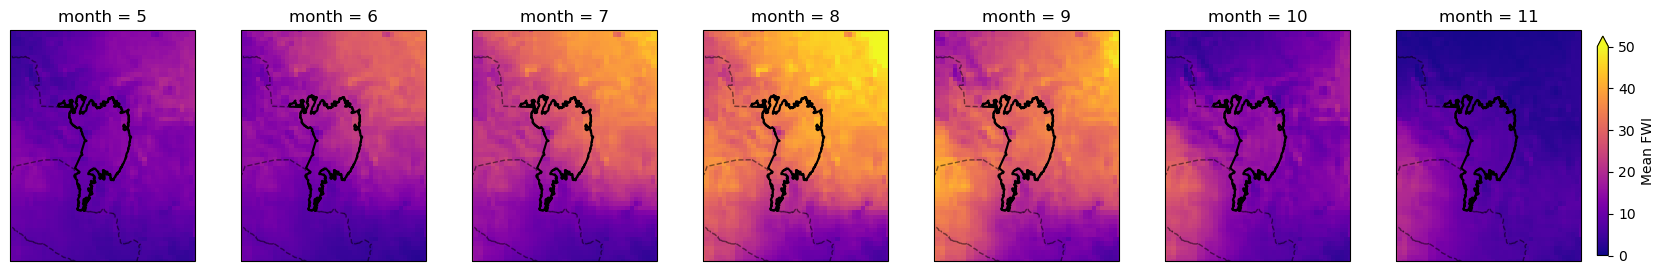

In [21]:
fwi_clim = fwi.sel(time = slice("2000","2020")).groupby("time.month").mean()

nc = 7; nr = 1
fig, axs = plt.subplots(nr, nc, figsize = (nc * 3, nr*3), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})

plot_kwargs = {"vmin" : 0, "vmax" : 50, "cmap" : "plasma"}
    
for i in range(nc):

    m = str(y)+"-"+str(range(5,12)[i]).rjust(2,"0")
    ax = axs[i]

    cbar = fwi_clim.sel(month = i+5).plot(ax = ax, **plot_kwargs, add_colorbar = False)

    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
    sf.boundary.plot(ax = ax, color = "k")
    
plt.colorbar(cbar, ax = axs, label = "Mean FWI", extend = "max", shrink = 0.95, pad = 0.01, fraction = 0.02)

plt.savefig("fig/fwi-clim.png")

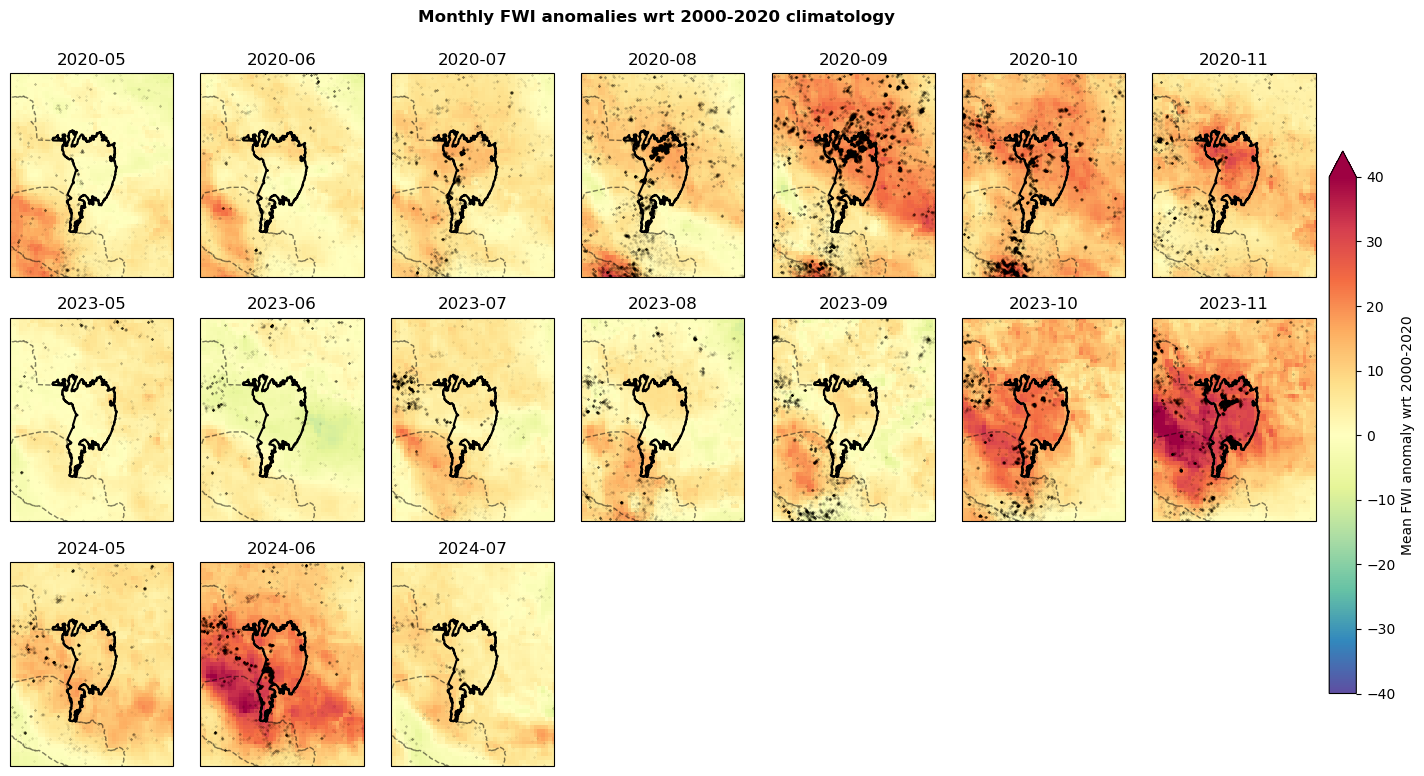

In [25]:
fwi_anom = fwi_m.groupby("time.month") - fwi_clim

nc = 7; nr = 3
fig, axs = plt.subplots(nr, nc, figsize = (nc * 2.5, nr*3), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(wspace = 0.1)

v = 40
plot_kwargs = {"vmin" : -v, "vmax" : v, "cmap" : "Spectral_r"}

for j in range(nr):
    y = [2020,2023,2024][j]
    
    for i in range(nc):
        
        m = str(y)+"-"+str(range(5,12)[i]).rjust(2,"0")
        ax = axs[j,i]
        
        if m > "2024-07":
            ax.set_axis_off()
            continue
        
        cbar = fwi_anom.sel(time = m).plot(ax = ax, **plot_kwargs, add_colorbar = False)
        df.loc[m].plot(ax = ax, marker = ".", color = "k", alpha = 0.1, markersize = 0.25)

        ax.set_title(m)
        ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
        sf.boundary.plot(ax = ax, color = "k")
        
plt.colorbar(cbar, ax = axs, label = "Mean FWI anomaly wrt 2000-2020", extend = "max", shrink = 0.95, pad = 0.01, fraction = 0.02)

plt.suptitle("Monthly FWI anomalies wrt 2000-2020 climatology", fontweight = "bold", y = 0.95)

plt.savefig("fig/fwi-anom.png")

## Time series within Pantanal region

## Compile & filter active fire data

In [5]:
df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326").clip(sf)

px_daily = df.resample("D").count()[["geometry"]]

## Cumulative fire activity

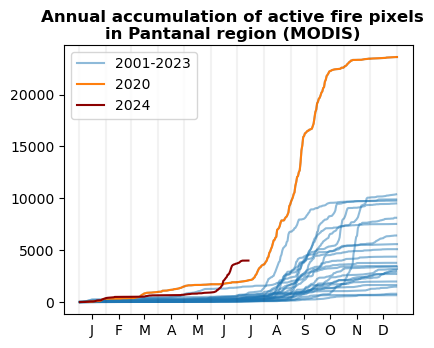

In [6]:
fig, ax = plt.subplots(figsize = (4.5,3.5), dpi = 100)

y = 2001
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "2001-2023")

for y in range(2002,2024):
    ts_y = px_daily.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "_years")
    
y = 2020
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:orange", label = "2020")

y = 2024
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "darkred", label = "2024")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

plt.suptitle("Annual accumulation of active fire pixels\nin Pantanal region (MODIS)", fontweight = "bold")

ax.legend()

plt.savefig("fig/cum_modis-pixels.png")

## Cumulative DSR

In [7]:
dsr = xr.open_dataset("data/era5_dsr.nc").dsr
rm = regionmask.mask_geopandas(sf, dsr.longitude, dsr.latitude)

ts = dsr.where(rm == 0).mean(["latitude", "longitude"])

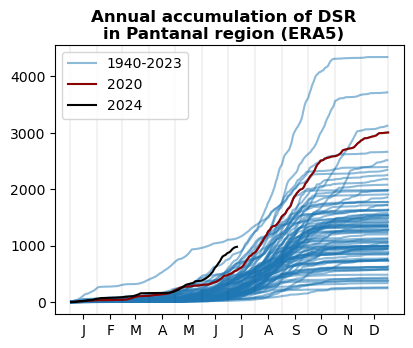

In [8]:
fig, ax = plt.subplots(figsize = (4.5,3.5), dpi = 100)

y = 1940
ts_y = ts.loc[str(y)]
ax.plot(ts_y.time.dt.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "1940-2023")

for y in range(1940,2024):
    ts_y = ts.loc[str(y)]
    ax.plot(ts_y.time.dt.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "_years")
    
# y = 1961
# ts_y = ts.loc[str(y)]
# ax.plot(ts_y.time.dt.dayofyear, ts_y.cumsum(), color = "gold", label = "1961")

# y = 1963
# ts_y = ts.loc[str(y)]
# ax.plot(ts_y.time.dt.dayofyear, ts_y.cumsum(), color = "orange", label = "1963")
    
y = 2020
ts_y = ts.loc[str(y)]
ax.plot(ts_y.time.dt.dayofyear, ts_y.cumsum(), color = "darkred", label = "2020")

y = 2024
ts_y = ts.loc[str(y)]
ax.plot(ts_y.time.dt.dayofyear, ts_y.cumsum(), color = "k", label = "2024")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

plt.suptitle("Annual accumulation of DSR\nin Pantanal region (ERA5)", fontweight = "bold")

ax.legend()

plt.savefig("fig/cum_era5-dsr.png")

## Seasonal cycle of DSR & fire activity

Text(0.5, 1.0, 'FWI')

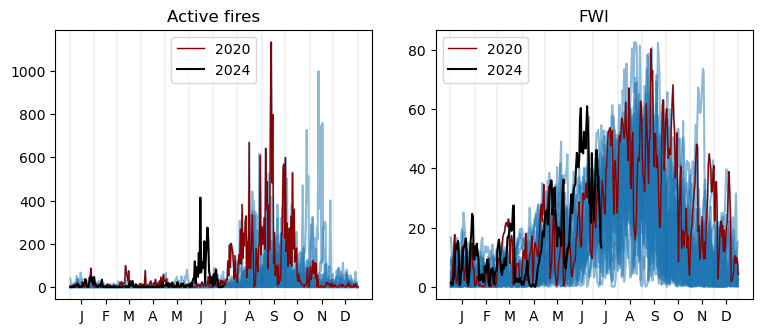

In [36]:
fig, axs = plt.subplots(ncols = 2, figsize = (9,3.5), dpi = 100, sharex = True)

ax = axs[0]

for y in range(2001,2024):
    ts_y = px_daily.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
    
y = "2020"; ts_y = px_daily.loc[y]; ax.plot(ts_y.index.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
y = "2024"; ts_y = px_daily.loc[y]; ax.plot(ts_y.index.dayofyear, ts_y, color = "k", label = y)

ax.legend()
ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

ax.set_title("Active fires")


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1]

for y in range(2001,2024):
    ts_y = ts.loc[str(y)]
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
    
y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
y = "2024"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)

ax.legend()
ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

ax.set_title("FWI (ERA5)")

## Correlation between DSR & fire activity

In [75]:
dsr_era5 = xr.open_dataset("data/fwi_daily_pantanal_era5.nc").dsr.resample(time = "MS").sum().sel(time = slice(None, "2024-06"))

df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326").clip(sf)

px_monthly = df.resample("MS").count()[["geometry"]].loc[slice(None, "2024-06")]

In [119]:
df = merge_byindex([dsr_era5.to_dataframe(), px_monthly]).dropna(axis = 0, how = "any")
df["log_px"] = np.log(df.geometry)

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


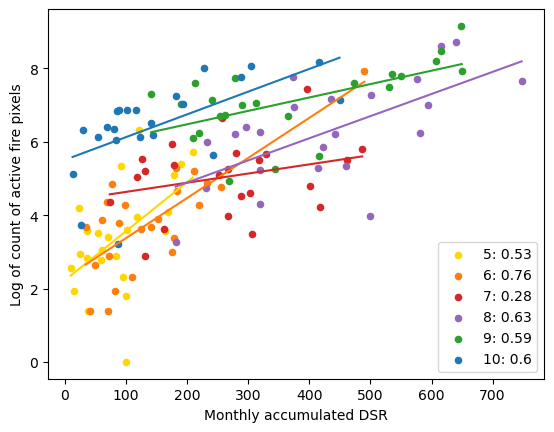

In [125]:
fig, ax = plt.subplots()

months = [5,6,7,8,9,10]
colours = ["gold","tab:orange", "tab:red", "tab:purple", "tab:green","tab:blue"]
for i in range(len(months)):
    
    df_m = df.loc[df.index.month == months[i]]
    
    # coeffs of best fit & correlation coefficient
    a,b = np.polyfit(df_m.dsr, df_m.log_px,1)
    r = str(round(df_m.corr()["dsr"]["log_px"],2))
    
    df_m.plot(ax = ax, color = colours[i], kind = "scatter", x = "dsr", y = "log_px", label = str(months[i])+": "+r,
              xlabel = "Monthly accumulated DSR", ylabel = "Log of count of active fire pixels")
    
    xyline(df_m.dsr, df_m.log_px, color = colours[i], ax = ax)
    
#     yticks = [50,250,500,1000,2000,5000,10000]
#     ax.set_yticks([np.log(yt) for yt in yticks])
#     ax.set_yticklabels(yticks)

## FWI

In [65]:
fwi = xr.open_dataset("data/era5_fwi_-67_-47_-27_-7.nc").fwinx
rm = regionmask.mask_geopandas(sf, fwi.longitude, fwi.latitude)
fwi = fwi.where(rm == 0).mean(["latitude", "longitude"])

fwi.to_netcdf("data/fwi_pantanal_era5.nc")
fwi.rename("fwi").assign_coords(time = fwi.time.dt.date).to_dataframe().to_csv("data/fwi_pantanal_era5.csv")

In [93]:
ts_list = {"Daily FWI" : fwi, 
           "7-day mean of FWI" : fwi.rolling(time = 7).mean(), 
           "15-day mean of FWI" : fwi.rolling(time = 15).mean(), 
           "30-day mean of FWI" : fwi.rolling(time = 30).mean(), 
           "Monthly mean of FWI" : fwi.resample(time = "M").mean()}

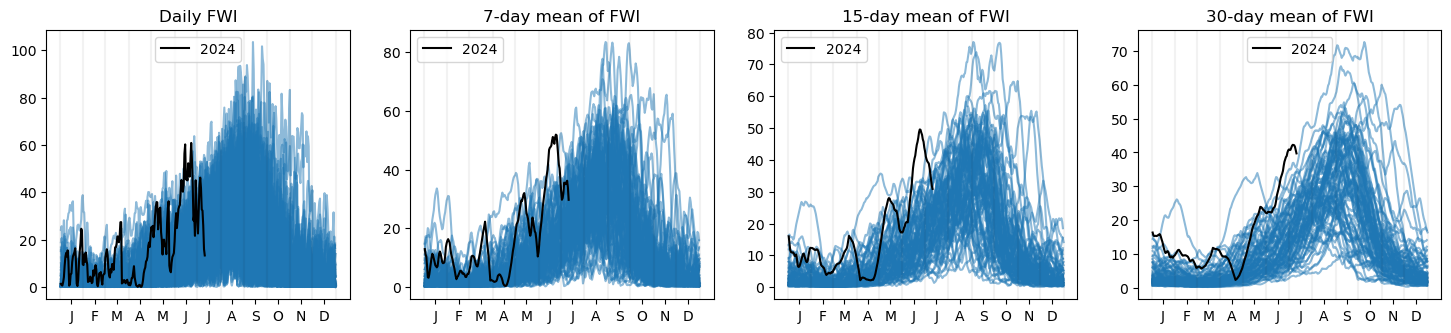

In [95]:
nc = 4
fig, axs = plt.subplots(ncols = nc, figsize = (nc * 4.5,3.5), dpi = 100, sharex = True)

for i in range(nc):
    
    ax = axs[i]
    ttl = list(ts_list.keys())[i]
    ts = ts_list[ttl]
    
    for y in range(1940,2024):
        ts_y = ts.loc[str(y)]
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
        
    # y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title(ttl)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
plt.savefig("fig/fwi-accumulations.png")

## DSR

In [4]:
dsr = xr.open_dataset("data/fwi_daily_pantanal_era5.nc").dsr

In [5]:
ts_list = {"Daily DSR" : dsr, 
           "7-day mean of DSR" : dsr.rolling(time = 7).mean(), 
           "15-day mean of DSR" : dsr.rolling(time = 15).mean(), 
           "30-day mean of DSR" : dsr.rolling(time = 30).mean(), 
           "Monthly mean of DSR" : dsr.resample(time = "M").mean()}

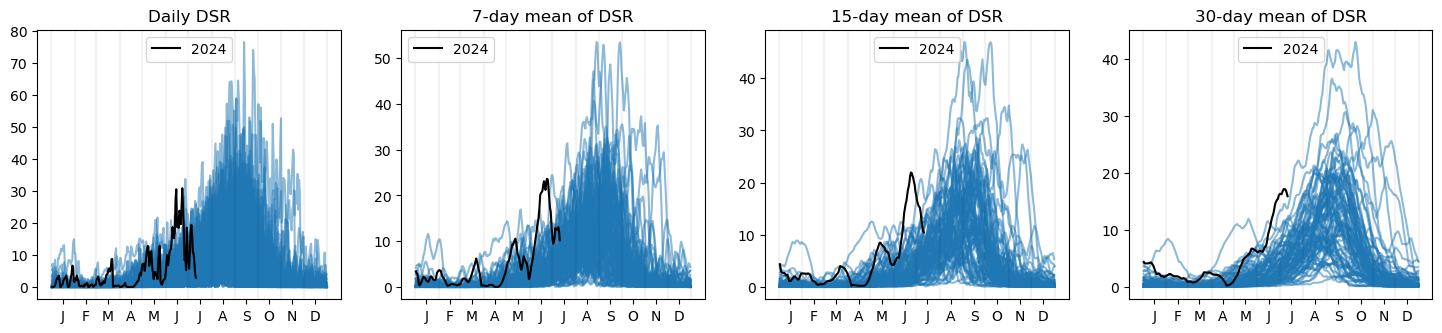

In [6]:
nc = 4
fig, axs = plt.subplots(ncols = nc, figsize = (nc * 4.5,3.5), dpi = 100, sharex = True)

for i in range(nc):
    
    ax = axs[i]
    ttl = list(ts_list.keys())[i]
    ts = ts_list[ttl]
    
    for y in range(1940,2024):
        ts_y = ts.loc[str(y)]
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
        
    # y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title(ttl)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
plt.savefig("fig/dsr-accumulations.png")

## Burned area

In [33]:
df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326").clip(sf)

px_daily = df.resample("D").count()[["geometry"]]
px_daily = px_daily.to_xarray().rename(acq_date = "time", geometry = "ba").ba
px_daily.to_netcdf("data/ba-px_pantanal_modis-80.nc")
px_daily.to_dataframe().to_csv("data/ba-px_pantanal_modis-80.csv")

In [96]:
ts_list = {"Daily burned area" : px_daily, 
           "7-day mean of burned area" : px_daily.rolling(time = 7).mean(), 
           "15-day mean of burned area" : px_daily.rolling(time = 15).mean(), 
           "30-day mean of burned area" : px_daily.rolling(time = 30).mean(), 
           "Monthly mean of burned area" : px_daily.resample(time = "M").mean()}

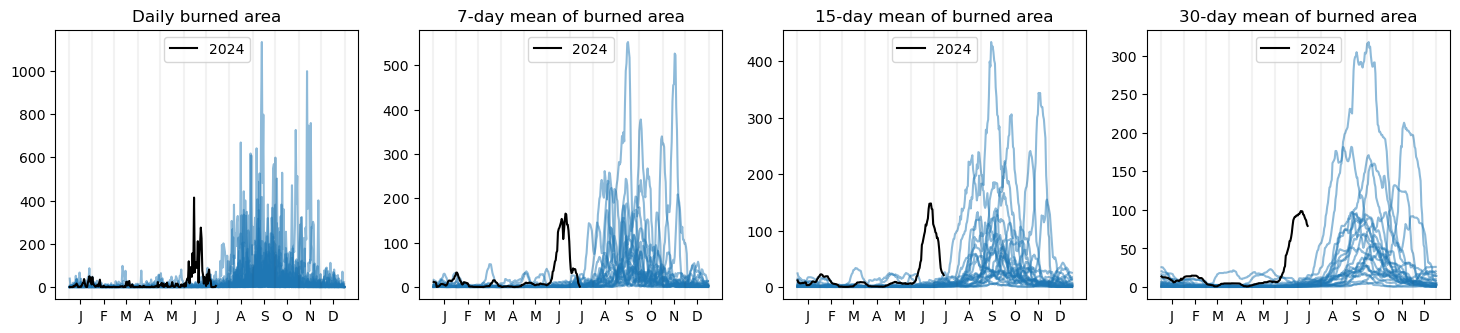

In [98]:
nc = 4
fig, axs = plt.subplots(ncols = nc, figsize = (nc * 4.5,3.5), dpi = 100, sharex = True)

for i in range(nc):
    
    ax = axs[i]
    ttl = list(ts_list.keys())[i]
    ts = ts_list[ttl]
    
    for y in range(2001,2024):
        ts_y = ts.loc[str(y)]
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
        
    # y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title(ttl)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
plt.savefig("fig/ba-accumulations.png")

# Sub-indices

In [30]:
ds = xr.open_dataset("data/fwi_daily_pantanal_era5.nc")
varbls = ["dsr", "bui", "isi", "ffmc", "dmc", "dc"]

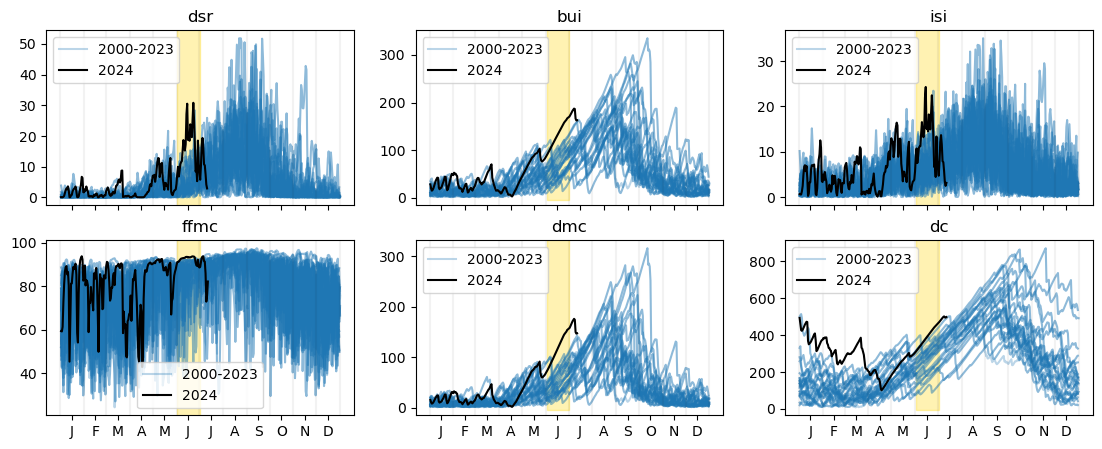

In [31]:
nc = 3; nr = 2

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)

for i in range(len(varbls)):
    
    ax = fig.axes[i]
    vnm = varbls[i]
    
    ts = ds[vnm]
    
    y = "2000"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, "tab:blue", alpha = 0.3, label = "2000-2023")
    for y in range(2001,2024):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
        
#     y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title(vnm)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.add_patch(Rectangle((ts.sel(time = "2024-06-01").time.dt.dayofyear.values,-5), 30, 1000, color = "gold", alpha = 0.3)) # 20-day period starting from July 1st
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
plt.savefig("fig/subindices_2024.png")

## Sub-subindices

In [25]:
ds = xr.open_dataset("data/era5_variables_pantanal_daily.nc")

rh = xr.open_dataset("data/rhum-mean_era5.nc")
rh_ts = rh.where(regionmask.mask_geopandas(sf, rh.longitude, rh.latitude) == 0).mean(["latitude", "longitude"])

ds = xr.merge([ds, rh_ts])

varbls = {"Precipitation" : "tp", "Mean temperature" : "t2m", "Wind speed" : "si10", "Relative humidity" : "r"}

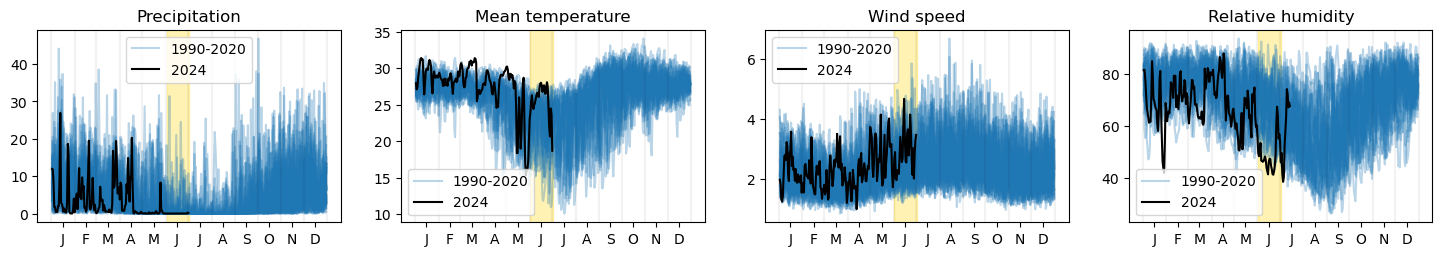

In [27]:
nc = len(varbls); nr = 1

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)

for i in range(len(varbls)):
    
    ax = fig.axes[i]
    ttl = list(varbls.keys())[i]
    vnm = varbls[ttl]
    
    ts = ds[vnm]
    
    y = "1990"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, "tab:blue", alpha = 0.3, label = "1990-2020")
    for y in range(1991,2020):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3, label = "_years")
        
#     y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title(ttl)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.add_patch(Rectangle((ts.sel(time = "2024-06-01").time.dt.dayofyear.values,-5), 30, 1000, color = "gold", alpha = 0.3)) # 20-day period starting from July 1st
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
plt.savefig("fig/subsubindices_2024.png")

# Trends in June variables

In [38]:
ds_june = ds.resample(time = "MS").mean().groupby("time.month")[6]
ds_june.assign_coords(time = ds_june.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts_obs/df_subsubindices_june_1950-2024.csv")

# Compare obs datasets

In [4]:
era5 = xr.open_dataset("data/fwi_daily_pantanal_era5.nc")
merra2 = xr.open_dataset("data/fwi_daily_pantanal_merra2-corrected.nc")
mswx = xr.open_dataset("data/fwi_daily_pantanal_mswx.nc")

## 2024 subindices & DSR

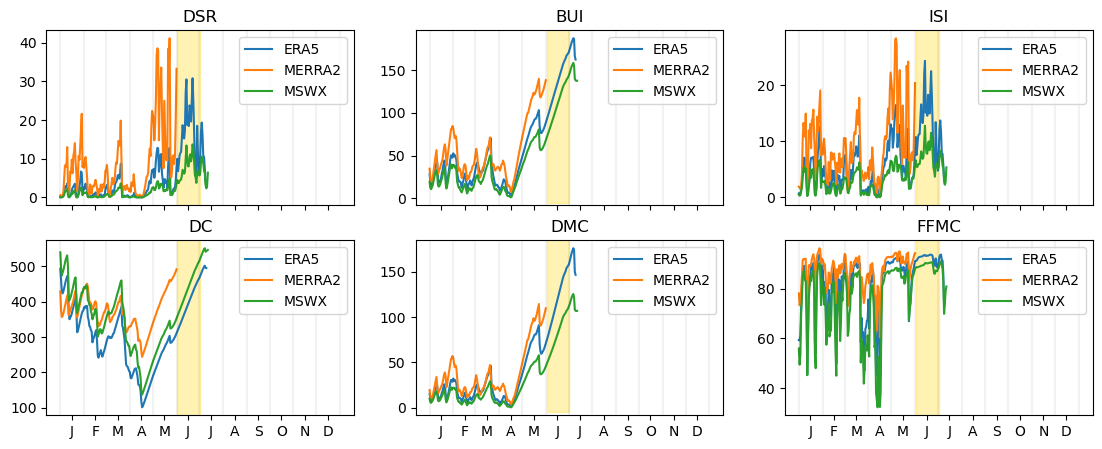

In [5]:
nc = 3; nr = 2
var_list = ["dsr", "bui", "isi", "dc", "dmc", "ffmc"]

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)
for i in range(len(var_list)):
    
    ax = fig.axes[i]
    vnm = var_list[i]
    
    ax.plot(era5[vnm].sel(time = "2024"), label = "ERA5")
    ax.plot(merra2[vnm].sel(time = "2024"), label = "MERRA2")
    ax.plot(mswx[vnm].sel(time = "2024"), label = "MSWX")
    
    ax.set_title(vnm.upper())
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.add_patch(Rectangle((era5.sel(time = "2024-06-01").time.dt.dayofyear.values,-5), 30, 1000, color = "gold", alpha = 0.3))
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

## Trends in June indices

In [32]:
era5 = xr.open_dataset("data/fwi_daily_pantanal_era5.nc").resample(time = "MS").mean().groupby("time.month")[6]
merra2 = xr.open_dataset("data/fwi_daily_pantanal_merra2-corrected.nc").resample(time = "MS").mean().groupby("time.month")[6]
mswx = xr.open_dataset("data/fwi_daily_pantanal_mswx.nc").resample(time = "MS").mean().groupby("time.month")[6]

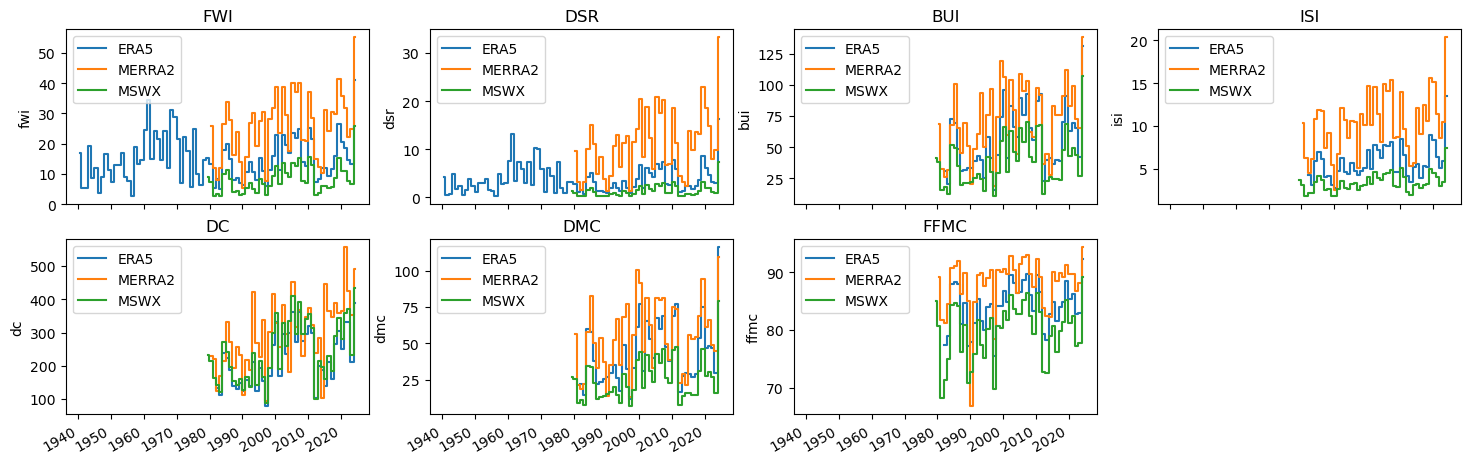

In [34]:
nc = 4; nr = 2
var_list = ["fwi", "dsr", "bui", "isi", "dc", "dmc", "ffmc"]

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)
for i in range(len(var_list)):
    
    ax = fig.axes[i]
    vnm = var_list[i]
    
    era5[vnm].plot(ax = ax, label = "ERA5", drawstyle = "steps-mid")
    merra2[vnm].plot(ax = ax, label = "MERRA2", drawstyle = "steps-mid")
    mswx[vnm].plot(ax = ax, label = "MSWX", drawstyle = "steps-mid")
    
    ax.set_title(vnm.upper())
    ax.set_ylabel(vnm)
    ax.set_xlabel("")
    ax.legend()
    
for i in range(len(var_list), len(fig.axes)):
    fig.axes[i].set_axis_off()
    
plt.savefig("fig/subindices-june.png")

## Relationship with active fire area

In [9]:
# monthly count of active fire area
df = pd.read_csv("data/modis_conf-80.csv", parse_dates = ["acq_date"], index_col = "acq_date")
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(x=df.longitude, y=df.latitude), crs = "EPSG:4326").clip(sf)
px_daily = df.resample("MS").count()[["geometry"]]

In [10]:
era5 = xr.open_dataset("data/fwi_daily_pantanal_era5.nc").resample(time = "MS").mean().fwi
merra2 = xr.open_dataset("data/fwi_daily_pantanal_merra2-corrected.nc").resample(time = "MS").mean().fwi
mswx = xr.open_dataset("data/fwi_daily_pantanal_mswx.nc").resample(time = "MS").mean().fwi

In [11]:
df = merge_byindex([px_daily, era5.rename("era5").to_dataframe(), merra2.rename("merra2").to_dataframe(), mswx.rename("mswx").to_dataframe()]).dropna(axis = 0, how = "any")
df["log_px"] = np.log(df.geometry)

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


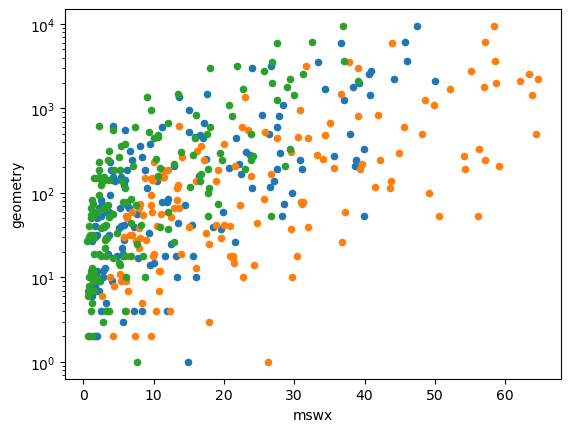

In [12]:
df.plot(kind = "scatter", x = "era5", y = "geometry")
df.plot(kind = "scatter", x = "merra2", y = "geometry", ax = plt.gca(), color = "tab:orange")
df.plot(kind = "scatter", x = "mswx", y = "geometry", ax = plt.gca(), color = "tab:green")

plt.yscale("log")

# Trends in seasonal rainfall

In [3]:
datasets = ["era5", "mswx", "chirps", "merge"]
nc = len(datasets)
seasons = ["JJA", "SON", "DJF", "MAM"]

precip = [xr.open_dataset("data/pr_daily_pantanal_"+ds+".nc").pr.sel(time = slice(None, "2024-06")) for ds in datasets]
seasonal = [pr.resample(time = "QS-JUN").sum().where(pr.resample(time = "MS").sum().resample(time = "QS-DEC").count() == 3).dropna("time", "any") for pr in precip]
seasonal_df = [xr.merge([da.assign_coords(time = da.time.dt.year+1) for da in [pr_s.groupby("time.season")[s].rename(s) for s in seasons]]).dropna("time", "any").to_dataframe() for pr_s in seasonal]

In [263]:
fig, axs = plt.subplots(ncols = 4, figsize = (4*4,3), sharey = True)

for i in range(4):
    
    ax = axs[i]
    s = seasons[i]

    [df[s].loc[slice("2000","2024")].plot(ax = ax) for df in seasonal_df]
    ax.set_title(s)
    
    ax.legend(datasets)
    
plt.savefig("fig/trends-in-seasonal-precip.png")

In [4]:
for i in range(len(datasets)):
    seasonal_df[i].to_csv("data/pr_seasonal_pantanal_"+datasets[i]+".csv")

## 2024 monthly vs climatology

In [260]:
def from_july(da):
    da = da.assign_coords(month = (da.month.values + 5) % 12, month_org = ("month", da.month.values))
    return da.sortby(da.month)

months = [m[:1] for m in pr.sel(time = slice("2023-07","2024-06")).resample(time = "MS").sum().time.dt.strftime("%b").values]

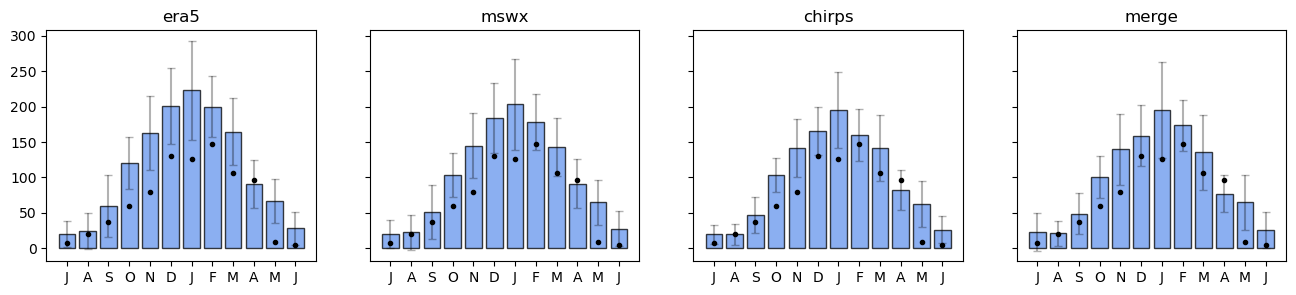

In [261]:
fig, axs = plt.subplots(ncols = nc, figsize = (nc*4,3), dpi = 100, sharey = True)

for i in range(nc):
    
    ax = axs[i]
    pr_m = precip[i].resample(time = "MS").sum()
    
    mmean = from_july(pr_m.sel(time = slice("1990","2020")).groupby("time.month").mean())
    msd = from_july(pr_m.sel(time = slice("1990","2020")).groupby("time.month").std())

    m_upper = mmean+msd
    m_lower = mmean-msd
    
    for m in range(12):
        ax.bar(m, mmean.isel(month = m), color = "cornflowerblue", edgecolor = "k", alpha = 0.75)
        ax.plot([m,m], [m_lower.isel(month = m), m_upper.isel(month = m)], color = "k", alpha = 0.3, marker = "_", solid_capstyle = "butt")

        ax.plot(m, pr_2024.isel(month = m), marker = ".", color = "k")

    ax.set_ylabel("")

    ax.set_xticks(range(12))
    ax.set_xticklabels(months)
    ax.set_title(datasets[i])
    
plt.savefig("fig/2024-precip-vs-climatology.png")